### Mask & No Mask Face Detection 

In [40]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [41]:
path_an = "../input/face-mask-detection/annotations"

In [42]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

In [43]:
for anno in glob.glob(path_an+"/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [45]:
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

In [30]:
np.sort(df.name.unique())

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object)

## Split Data to Train, Validation, and Test.

In [46]:
fileNames = [*os.listdir("../input/face-mask-detection/images")]
len(fileNames)

853

In [47]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fileNames, test_size=0.1, random_state=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print("Length of Train =",len(train))
print("="*30)
print("Length of Valid =",len(val))
print("="*30)
print("Length of test =", len(test))

Length of Train = 767
Length of Valid = 61
Length of test = 25


In [48]:
os.mkdir('./yolov5/data/train')
os.mkdir('./yolov5/data/val')
os.mkdir('./yolov5/data/test')
os.mkdir('./yolov5/data/train/images')
os.mkdir('./yolov5/data/train/labels')
os.mkdir('./yolov5/data/test/images')
os.mkdir('./yolov5/data/test/labels')
os.mkdir('./yolov5/data/val/images')
os.mkdir('./yolov5/data/val/labels')

FileExistsError: [Errno 17] File exists: './yolov5/data/train'

In [50]:
from PIL import Image

def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open("../input/face-mask-detection/images/"+image)
        img1 = img.resize((640, 480))
        _ = img1.save("./yolov5/data/"+folder_Name+"/images/"+image)
        

In [35]:
copyImages(train, "train")
copyImages(val, "val")
copyImages(test, "test")

In [51]:
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

In [52]:
df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

In [53]:
df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

In [ ]:
df.head()

In [ ]:
df['xbbox'] = df['xmax']-df['xmin']
df['ybbox'] = df['ymax']-df['ymin']

sns.set()
sns.scatterplot(x='xbbox',  y='ybbox', data=df)
plt.show()

In [ ]:
df = df.astype('string')

In [36]:
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+" "+row["x_center"]+" "+row["y_center"]\
                        +" "+row["box_height"]+" "+row["box_width"])
            
        text = "\n".join(box_list)
        with open("./yolov5/data/"+data_name+"/labels/"+name+".txt", "w") as file:
            file.write(text)   
            
create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

In [56]:
%cd yolov5

/kaggle/working/yolov5


In [58]:
from IPython.display import Image, Video, clear_output  # to display images
import torch
from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 2023-8-6 Python-3.7.12 torch-1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 15.6 GB RAM, 4959.2/8062.4 GB disk)


In [60]:
yaml_text = """train: data/train/images
val: data/train/images   
nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

In [61]:
with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

In [62]:
%cat data/data.yaml

train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

In [63]:

from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [64]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3 
depth_multiple: 0.33  
width_multiple: 0.50  # layer channel 

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]], 

    [[17, 20, 23], 1, Detect, [nc, anchors]],  
    ]

## Train Model

In [67]:
start = datetime.now()
!python train.py --img 640 --batch 32 --epochs 2 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights '' --name yolov5s_results  
end = datetime.now()

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with 

In [113]:
# train yolov5s on custom data for 100 epochs
# time its performance

start = datetime.now()
!python train.py --img 640 --batch 32 --epochs 10 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache
end = datetime.now()

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with 

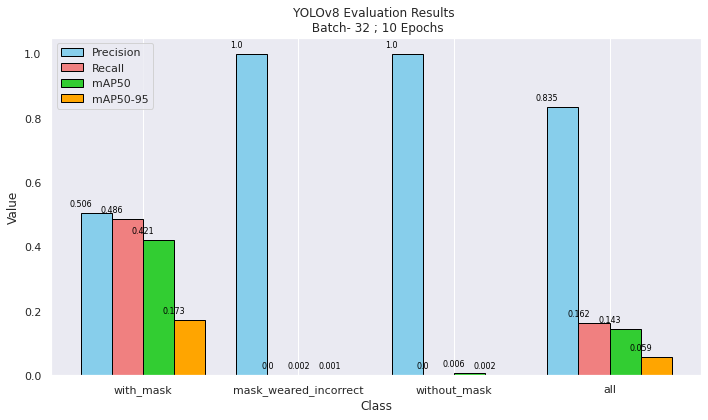

In [114]:

import matplotlib.pyplot as plt
import numpy as np

# Class names and corresponding metrics
class_names = ['with_mask', 'mask_weared_incorrect', 'without_mask', 'all']
precision = [0.506, 1.0, 1.0, 0.835]
recall = [0.486, 0.0, 0.0, 0.162]
mAP50 = [0.421, 0.00236, 0.00612, 0.143]
mAP50_95 = [0.173, 0.000716, 0.00196, 0.0586]

# Set the bar width
bar_width = 0.2

# Position of bars on the x-axis
r1 = np.arange(len(class_names))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(r1, precision, color='skyblue', width=bar_width, edgecolor='black', label='Precision')
plt.bar(r2, recall, color='lightcoral', width=bar_width, edgecolor='black', label='Recall')
plt.bar(r3, mAP50, color='limegreen', width=bar_width, edgecolor='black', label='mAP50')
plt.bar(r4, mAP50_95, color='orange', width=bar_width, edgecolor='black', label='mAP50-95')

# Add values above bars
for i, v in enumerate(precision):
    plt.text(i - bar_width / 2, v + 0.02, str(round(v, 3)), color='black', ha='center', fontsize=8)
for i, v in enumerate(recall):
    plt.text(i + bar_width / 2, v + 0.02, str(round(v, 3)), color='black', ha='center', fontsize=8)
for i, v in enumerate(mAP50):
    plt.text(i + bar_width * 1.5, v + 0.02, str(round(v, 3)), color='black', ha='center', fontsize=8)
for i, v in enumerate(mAP50_95):
    plt.text(i + bar_width * 2.5, v + 0.02, str(round(v, 3)), color='black', ha='center', fontsize=8)

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Value')
plt.title('YOLOv8 Evaluation Results \n Batch- 32 ; 10 Epochs')
plt.xticks([r + 1.5 * bar_width for r in range(len(class_names))], class_names)
plt.legend(loc='upper left')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


In [115]:
print("Runtime =",end-start)

Runtime = 0:07:27.457906


In [116]:
start = datetime.now()
!python train.py --img 640 --batch 32 --epochs 20 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache
end = datetime.now()

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with 

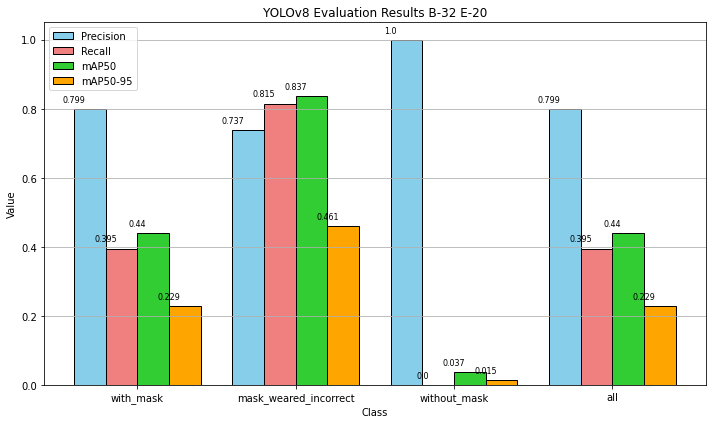

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Class names and corresponding metrics
class_names = ['with_mask', 'mask_weared_incorrect', 'without_mask', 'all']
precision = [0.799, 0.737, 1.0, 0.799]
recall = [0.395, 0.815, 0.0, 0.395]
mAP50 = [0.44, 0.837, 0.0366, 0.44]
mAP50_95 = [0.229, 0.461, 0.0151, 0.229]

# Set the bar width
bar_width = 0.2

# Position of bars on the x-axis
r1 = np.arange(len(class_names))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(r1, precision, color='skyblue', width=bar_width, edgecolor='black', label='Precision')
plt.bar(r2, recall, color='lightcoral', width=bar_width, edgecolor='black', label='Recall')
plt.bar(r3, mAP50, color='limegreen', width=bar_width, edgecolor='black', label='mAP50')
plt.bar(r4, mAP50_95, color='orange', width=bar_width, edgecolor='black', label='mAP50-95')

# Add values above bars
for i, v in enumerate(precision):
    plt.text(i - bar_width / 2, v + 0.02, str(round(v, 3)), color='black', ha='center', fontsize=8)
for i, v in enumerate(recall):
    plt.text(i + bar_width / 2, v + 0.02, str(round(v, 3)), color='black', ha='center', fontsize=8)
for i, v in enumerate(mAP50):
    plt.text(i + bar_width * 1.5, v + 0.02, str(round(v, 3)), color='black', ha='center', fontsize=8)
for i, v in enumerate(mAP50_95):
    plt.text(i + bar_width * 2.5, v + 0.02, str(round(v, 3)), color='black', ha='center', fontsize=8)

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Value')
plt.title('YOLOv8 Evaluation Results B-32 E-20')
plt.xticks([r + 1.5 * bar_width for r in range(len(class_names))], class_names)
plt.legend(loc='upper left')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


In [118]:
start = datetime.now()
!python train.py --img 640 --batch 16 --epochs 20 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache
end = datetime.now()

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with 

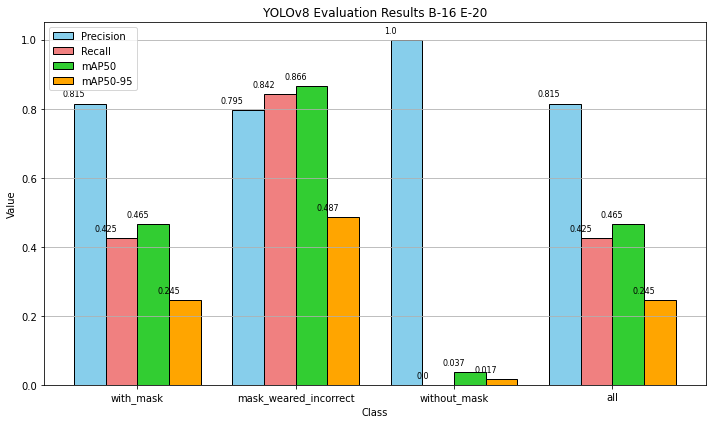

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Class names and corresponding metrics
class_names = ['with_mask', 'mask_weared_incorrect', 'without_mask', 'all']
precision = [0.815, 0.795, 1.0, 0.815]
recall = [0.425, 0.842, 0.0, 0.425]
mAP50 = [0.465, 0.866, 0.0369, 0.465]
mAP50_95 = [0.245, 0.487, 0.017, 0.245]

# Set the bar width
bar_width = 0.2

# Position of bars on the x-axis
r1 = np.arange(len(class_names))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(r1, precision, color='skyblue', width=bar_width, edgecolor='black', label='Precision')
plt.bar(r2, recall, color='lightcoral', width=bar_width, edgecolor='black', label='Recall')
plt.bar(r3, mAP50, color='limegreen', width=bar_width, edgecolor='black', label='mAP50')
plt.bar(r4, mAP50_95, color='orange', width=bar_width, edgecolor='black', label='mAP50-95')

# Add values above bars
for i, v in enumerate(precision):
    plt.text(i - bar_width / 2, v + 0.02, str(round(v, 3)), color='black', ha='center', fontsize=8)
for i, v in enumerate(recall):
    plt.text(i + bar_width / 2, v + 0.02, str(round(v, 3)), color='black', ha='center', fontsize=8)
for i, v in enumerate(mAP50):
    plt.text(i + bar_width * 1.5, v + 0.02, str(round(v, 3)), color='black', ha='center', fontsize=8)
for i, v in enumerate(mAP50_95):
    plt.text(i + bar_width * 2.5, v + 0.02, str(round(v, 3)), color='black', ha='center', fontsize=8)

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Value')
plt.title('YOLOv8 Evaluation Results B-16 E-20')
plt.xticks([r + 1.5 * bar_width for r in range(len(class_names))], class_names)
plt.legend(loc='upper left')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


In [20]:
start = datetime.now()
!python train.py --img 640 --batch 32 --epochs 40 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache
end = datetime.now()

python: can't open file 'train.py': [Errno 2] No such file or directory


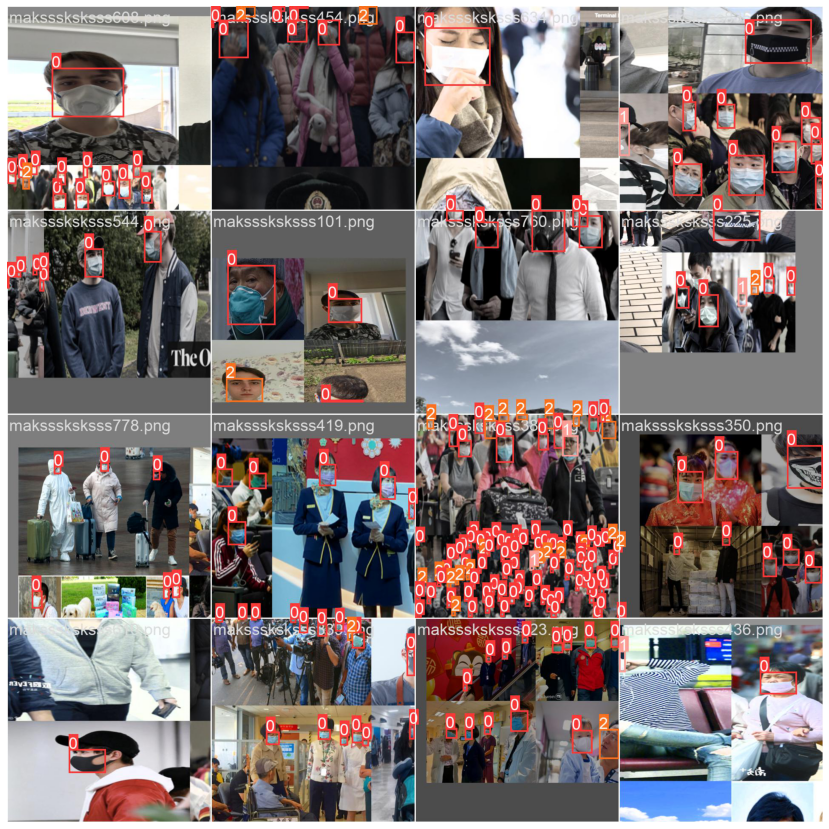

In [119]:
img = plt.imread('runs/train/yolov5s_results/train_batch0.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

## Evaluation Model

In [120]:
!python detect.py --source data/test/images/ --weight runs/train/yolov5s_results/weights/best.pt --name expTestImage --conf 0.4

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=data/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=expTestImage, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-203-g0897415 Python-3.7.12 torch-1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
image 1/25 /kaggle/working/yolov5/data/test/images/maksssksksss151.png: 480x640 4 with_masks, 13.4ms
image 2/25 /kaggle/working/yolov5/data/test/images/maksssksksss164.png: 480x640 3 with_masks, 9.6ms
image 3/25 /kaggle/working/yolov5/data/test/images/maksssksksss173.png: 480x640 3 with_masks, 9.9ms
image 4/25 /kaggle/working

In [121]:
color_dict = {
    'with_mask': (0, 255, 0),
    'mask_weared_incorrect':  (0, 0, 255),
    'without_mask': (255, 0, 0) 
}

In [122]:
def show_image(img_id):
    df_image = df[df.file==img_id]
    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    path = 'data/test/images/'+img_id+'.png'
    img = plt.imread(path)

    imge = img.copy()

    for index in range(len(df_image)):
        row = df_image.iloc[index]
        cv2.rectangle(imge, 
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=2)

    img_pred = plt.imread('runs/detect/expTestImage/'+img_id+".png")
    # ===================================
    plt.figure(figsize=(14,17))

    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Image with Truth Box')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')


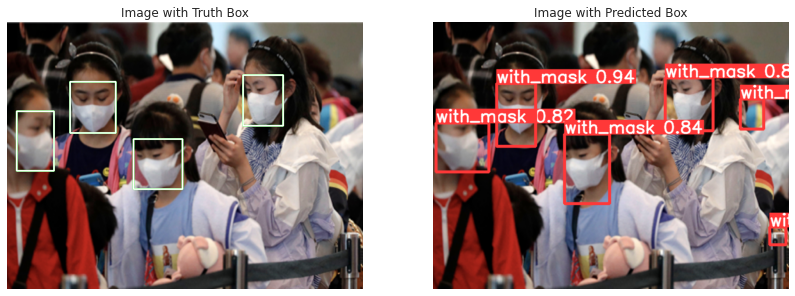

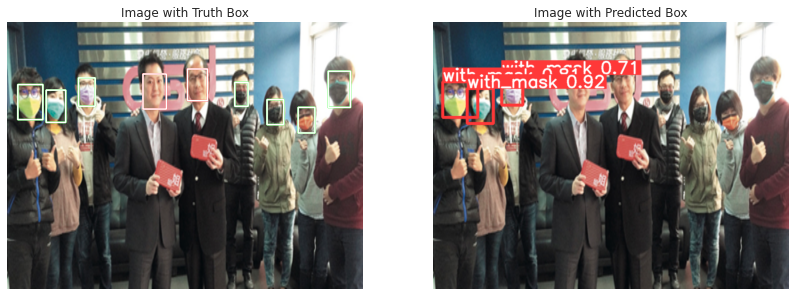

In [123]:
show_image("maksssksksss466") 
show_image("maksssksksss164") 
plt.show()

In [124]:
%cd ../

/kaggle/working


In [125]:
!python yolov5/detect.py --source ../input/facemaskdetectionvideo/Wear-Mask.mp4 --weight yolov5/runs/train/yolov5s_results/weights/best.pt --name video --conf 0.4

detect: weights=['yolov5/runs/train/yolov5s_results/weights/best.pt'], source=../input/facemaskdetectionvideo/Wear-Mask.mp4, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=video, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-203-g0897415 Python-3.7.12 torch-1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
Traceback (most recent call last):
  File "yolov5/detect.py", line 262, in <module>
    main(opt)
  File "yolov5/detect.py", line 257, in main
    run(**vars(opt))
  File "/opt/conda/lib/python3.7/site-packages/torch/autograd/grad_mode.py", line 28, in decorate_context
    return func

<a href="yolov5/runs/detect/video/Wear-Mask.mp4">Download Test Video</a>

### End :)

In [126]:
from datetime import datetime
import torch
from yolov5 import utils

start = datetime.now()

# Assuming the following imports and model initialization are already present
from yolov5.models.experimental import attempt_load
from yolov5.utils.datasets import create_dataloader
from yolov5.utils.general import check_dataset, check_img_size
from yolov5.utils.torch_utils import select_device, init_seeds

# ... (other setup code) ...

# Start training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for i, (imgs, targets, _, _) in enumerate(train_loader):
        # Move images and targets to the device
        imgs = imgs.to(device)
        targets = targets.to(device)
        
        # Forward pass and compute loss
        loss, _, _ = model(imgs, targets)
        loss.backward()
        
        # Update model weights
        optimizer.step()
        optimizer.zero_grad()
        
        # Update running loss
        running_loss += loss.item()
        
        # Print loss for each iteration (batch)
        print(f"Epoch [{epoch + 1}/{epochs}], Iteration [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
    # Calculate average loss per epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Average Loss: {avg_loss:.4f}")

# Save the model after training
torch.save(model.state_dict(), f'{name}.pt')

end = datetime.now()
print(f"Training Time: {end - start}")



ModuleNotFoundError: No module named 'yolov5.utils.datasets'